In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from albumentations import (
    HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast, Compose,Resize
)
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data distrubution

In [6]:
df = pd.read_csv('coco_val_subset.csv')
for i in range(5):
    df[f'category_{i+1}'] = df['categories'].apply(lambda x: 1 if i+1 in eval(x) else 0)


Text(0.5, 0, 'Categories')

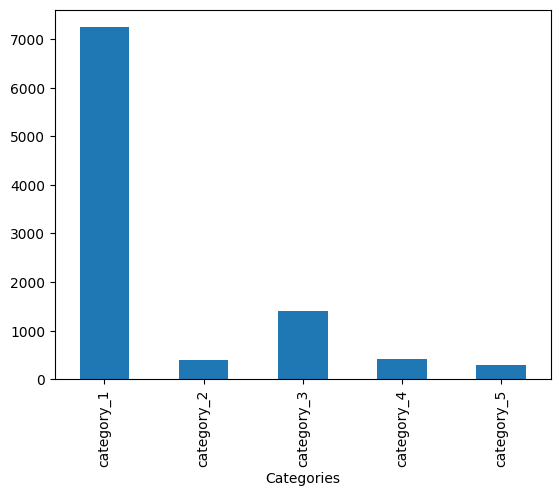

In [10]:
df[['category_1', 'category_2', 'category_3','category_4', 'category_5']].sum().plot(kind='bar')
plt.xlabel('Categories')

## Augmentations

In [7]:
transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
    Rotate(limit=15,border_mode=0,p=0.7, fill=0.5,interpolation=1),
    Resize(256, 256)
], is_check_shapes=False)

test_transform = Compose([
    Resize(256, 256)
], is_check_shapes=False)

## dataset and loader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, src_dir, transform=None):
        self.src_dir = src_dir
        self.transform = transform
        self.imgs = os.listdir(src_dir+"/images")


    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]

        image = io.imread(os.path.join(f"{self.src_dir}/images", img_name))
        image = image/255
     
        label = io.imread(os.path.join(f"{self.src_dir}/masks", img_name.replace("jpg","png")))
        if self.transform:
            out = self.transform(image=image,mask=label)
            image, label = out['image'], out['mask']

        image = np.array(image)
        if image.ndim == 2:  # Grayscale
            image = np.stack([image] * 3, axis=-1)
        
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  
        label = torch.tensor(np.array(label),dtype=torch.float32)
        
        return image, label

In [9]:
train_dataset = CustomDataset(src_dir="coco_val_subset/train", transform=test_transform)
val_dataset = CustomDataset(src_dir="coco_val_subset/val", transform=test_transform)
test_dataset = CustomDataset(src_dir="coco_val_subset/test", transform=test_transform)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True,drop_last=True)

torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


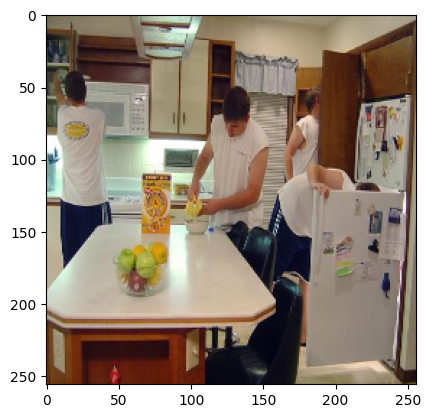

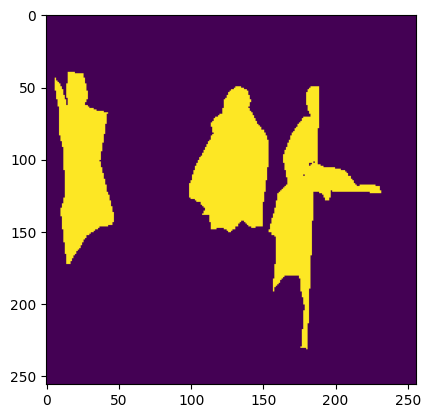

In [45]:
i,j = next(iter(train_loader))
print(i.shape)
print(j.shape)
plt.imshow(i[2].permute(1,2,0).numpy())
plt.show()
plt.imshow(j[2].squeeze(0).numpy())

## Model

In [2]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
from tqdm import tqdm

In [3]:
model = deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=6)

c:\Users\ksrma\pythonProject\git_projects\image_segmentation\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ksrma\pythonProject\git_projects\image_segmentation\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from monai.losses import TverskyLoss
loss_fn = TverskyLoss(alpha=0.7, beta=0.3)
# loss = loss_fn(y_pred, y_true)

## Training

In [12]:
from torchmetrics.segmentation import DiceScore
from torchmetrics import JaccardIndex
from torchmetrics.classification import MulticlassAccuracy
import wandb
import csv


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
model.to(device)

#metrics
num_classes = 6

iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes, average='macro').to(device)
mac_dice = DiceScore(num_classes=6,average='macro', include_background=True,input_format='index').to(device)
mic_dice = DiceScore(num_classes=6,average='micro', include_background=True,input_format='index').to(device)
pixel_acc_metric = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)
per_class_pixel_acc_metric = MulticlassAccuracy(num_classes=num_classes, average='none').to(device)



using cuda


In [100]:
# Initialize wandb
wandb.init(project="test_run", name="DeepLabV3_Mobilenet_train1", config={
    "epochs": 20,
    "model": "DeepLabV3_MobilenetV3_large",
    "num_classes": 6,
})

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [101]:
epochs = 20
best_val_loss = 1
folder = "models/DeepLabV3_mobilenet"
log_file = f"{folder}/logs.csv"

if not os.path.exists(folder):
    os.makedirs(folder)

start_time = time.time()

for epoch in range(epochs):
    # Training Phase
    model.train()
    train_loss = 0

    mac_dice.reset()
    mic_dice.reset()
    iou_metric.reset()
    pixel_acc_metric.reset()
    per_class_pixel_acc_metric.reset()

    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        images, masks = images.to(device), masks.long().to(device)
        optimizer.zero_grad()

        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        train_loss += loss.item()

        mac_dice.update(preds, masks)
        mic_dice.update(preds, masks)
        iou_metric.update(preds, masks)
        pixel_acc_metric.update(preds, masks)
        per_class_pixel_acc_metric.update(preds, masks)

    train_loss /= len(train_loader)

    log_dict ={
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train IoU": iou_metric.compute().item(),
        "Train Dice (Macro)": mac_dice.compute().item(),
        "Train Dice (Micro)": mic_dice.compute().item(),
        "Train Pixel Acc": pixel_acc_metric.compute().item(),
    }
    for i, acc in enumerate(per_class_pixel_acc_metric.compute().cpu().numpy()):
        log_dict[f"Train Pixel Acc Class {i}"] = acc

    # Validation Phase
    model.eval()
    val_loss = 0

    mac_dice.reset()
    mic_dice.reset()
    iou_metric.reset()
    pixel_acc_metric.reset()
    per_class_pixel_acc_metric.reset()

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f"Validation Epoch {epoch + 1}"):
            images, masks = images.to(device), masks.long().to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)


            preds = torch.argmax(outputs, dim=1)

            val_loss += loss.item()

            mac_dice.update(preds, masks)
            mic_dice.update(preds, masks)
            iou_metric.update(preds, masks)
            pixel_acc_metric.update(preds, masks)
            per_class_pixel_acc_metric.update(preds, masks)

    val_loss /= len(test_loader)

    log_dict2 ={
        "Epoch": epoch + 1,
        "Val Loss": val_loss,
        "Val IoU": iou_metric.compute().item(),
        "Val Dice (Macro)": mac_dice.compute().item(),
        "Val Dice (Micro)": mic_dice.compute().item(),
        "Val Pixel Acc": pixel_acc_metric.compute().item(),
    }
    for i, acc in enumerate(per_class_pixel_acc_metric.compute().cpu().numpy()):
        log_dict2[f"Val Pixel Acc Class {i}"] = acc

    log_dict.update(log_dict2)
    
    # Log to wandb
    wandb.log(log_dict)

    # Save model
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"{folder}/raw_model{epoch+1}.pth")
        print(f"Saved Model at Epoch {epoch + 1}")

    if val_loss < best_val_loss :
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"{folder}/raw_model{epoch+1}_best.pth")
        print(f"Saved Best Model at Epoch {epoch + 1}")

end_time = time.time()
print(f"Training Time: {end_time - start_time}")
print("Training Complete!")
wandb.finish()

Validation Epoch 1: 100%|██████████| 200/200 [00:18<00:00, 10.74it/s]


Saved Best Model at Epoch 1


Validation Epoch 2: 100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


Saved Best Model at Epoch 2


Training Epoch 3:  58%|█████▊    | 931/1600 [02:00<01:26,  7.74it/s]


KeyboardInterrupt: 

## Test set

In [13]:

folder="models/DeepLabV3_mobilenet"
model = deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=6)
model.load_state_dict(torch.load(f"{folder}/raw_model24_best.pth"))
model.to(device)
model.eval()
#test the model on test set
iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes, average='macro').to(device)
iou_metric_per_class = JaccardIndex(task="multiclass", num_classes=num_classes, average='none').to(device)
mac_dice = DiceScore(num_classes=6,average='macro', include_background=True,input_format='index').to(device)

In [14]:
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc=f"Testing"):
        images, masks = images.to(device), masks.long().to(device)
        outputs = model(images)['out']
        loss = criterion(outputs, masks)


        preds = torch.argmax(outputs, dim=1)
        mac_dice.update(preds, masks)
        iou_metric.update(preds, masks)
        iou_metric_per_class.update(preds, masks)

metrics = {"Test Dice (Macro)": mac_dice.compute().item(),
"Test IOU": iou_metric.compute().item(),
"Test IOU per class": iou_metric_per_class.compute().cpu().numpy(),}

for k, v in metrics.items():
    print(f"{k}: {v}")

Testing: 100%|██████████| 200/200 [00:16<00:00, 12.01it/s]

Test Dice (Macro): 0.2644263505935669
Test IOU: 0.5240954160690308
Test IOU per class: [0.9157293  0.6997592  0.26704445 0.41223326 0.4151318  0.43467453]


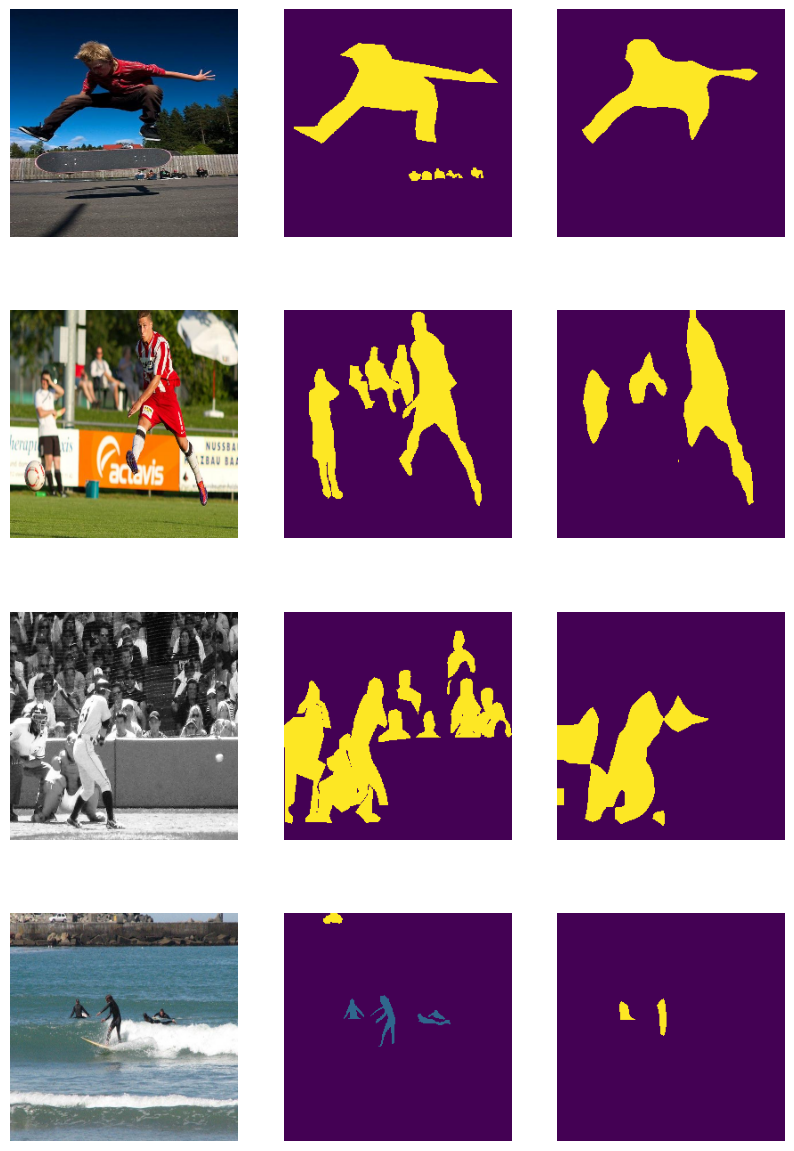

In [32]:
img,mask = next(iter(test_loader))
img = img.to(device)
mask = mask.to(device)
model.eval()
with torch.no_grad():
    pred = model(img)['out']
    pred = torch.argmax(pred, dim=1)
    pred = pred.cpu().numpy()

    mask = mask.cpu().numpy()
    img = img.cpu().numpy()
    img = img.transpose(0,2,3,1)

plt.figure(figsize=(10,15))
k=1
for i in range(4):
    plt.subplot(4,3,k)
    plt.imshow(img[i])
    plt.axis('off')
    plt.subplot(4,3,k+1)
    plt.imshow(mask[i])
    plt.axis('off')
    plt.subplot(4,3,k+2)
    plt.imshow(pred[i])
    plt.axis('off')
    k+=3
plt.show()
